In [27]:
# Dependencies
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.stats import linregress
import numpy as np
from sklearn import datasets

In [21]:
hot100 = os.path.join("data", "Hot100AudioFeatures.csv")

# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hot_100_df = pd.read_csv(hot100, encoding="ISO-8859-1")
hot_100_df.head()

,ï»¿SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,True,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,True,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [22]:
hot100_clean_df = hot_100_df.drop(columns=['spotify_track_preview_url','spotify_track_album','spotify_track_explicit','spotify_track_duration_ms'],axis=1)


In [23]:


hot100_clean_df.dropna(inplace=True)

hot100_clean_df.reset_index(inplace=True)
hot100_clean_df.rename(columns = {'ï»¿SongID':'Song'},inplace=True)
hot100_clean_df


,index,Song,Performer,Song,spotify_genre,spotify_track_id,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.017000,0.000016,0.1790,0.623,80.002,4.0
1,2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.371000,0.000000,0.2310,0.323,95.799,4.0
2,3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,86.0,0.542,0.674,6.0,-4.169,1.0,0.2100,0.058800,0.000000,0.0955,0.667,76.388,4.0
3,4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,61.0,0.948,0.623,8.0,-5.725,0.0,0.1680,0.001240,0.000001,0.0716,0.856,135.979,4.0
4,5,The ArcherTaylor Swift,Taylor Swift,The Archer,"['dance pop', 'pop', 'post-teen pop']",3pHkh7d0lzM2AldUtz2x37,76.0,0.292,0.574,0.0,-9.375,1.0,0.0401,0.120000,0.005690,0.0663,0.166,124.344,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23560,28486,"Tonight, Tonight, TonightGenesis",Genesis,"Tonight, Tonight, Tonight","['album rock', 'art rock', 'classic rock', 'me...",3qmYlsTbC9CD9SGoVmaEDa,42.0,0.571,0.502,7.0,-14.405,1.0,0.0303,0.015800,0.014000,0.0849,0.316,98.058,4.0
23561,28487,"Tonight, TonightThe Smashing Pumpkins",The Smashing Pumpkins,"Tonight, Tonight","['alternative metal', 'alternative rock', 'gru...",7bu0znpSbTks0O6I98ij0W,69.0,0.287,0.670,6.0,-9.381,1.0,0.0368,0.000063,0.748000,0.2370,0.222,148.928,4.0
23562,28488,Tonight's The Night (Gonna Be Alright)Rod Stewart,Rod Stewart,Tonight's The Night (Gonna Be Alright),"['adult standards', 'mellow gold', 'soft rock']",10LRRKPmx8uHcSxLVWK0ct,55.0,0.550,0.514,11.0,-12.617,1.0,0.0523,0.336000,0.125000,0.3820,0.724,136.542,3.0
23563,28489,Tonight's The NightBLACKstreet,BLACKstreet,Tonight's The Night,"['boy band', 'dance pop', 'hip hop', 'hip pop'...",3scEwKiAkfdPUdZ6k1AEoW,32.0,0.585,0.573,6.0,-5.561,0.0,0.0759,0.133000,0.000011,0.1730,0.591,76.060,4.0


In [38]:
#Adding function to plot information
def plot_func(xvalues,yvalues,x_loc,y_loc,x_label,y_label,title):
    
    # Generate the pearson coeeficient
    correlation = sts.pearsonr(xvalues,yvalues)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

    # Get the linear regression model
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)

    # Create the line using the slope and intercept and print out the formula
    regress_values = xvalues * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot information
    plt.scatter(xvalues,yvalues)
    plt.plot(xvalues,regress_values,"r-")
    plt.annotate(line_eq,(x_loc,y_loc),fontsize=15,color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


The correlation between both factors is -0.21


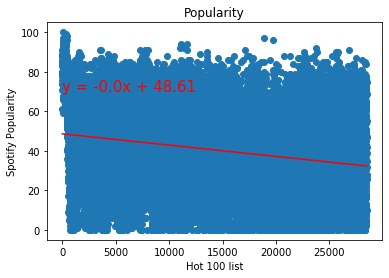

In [45]:
# create a scatter plot based on the track popularity versus the ranking in the top 100.  
# We need to repeat this for the other factors
plot_func(hot100_clean_df['index'], hot100_clean_df['spotify_track_popularity'],0,70,'Hot 100 list',
          'Spotify Popularity','Popularity')


The correlation between both factors is -0.07


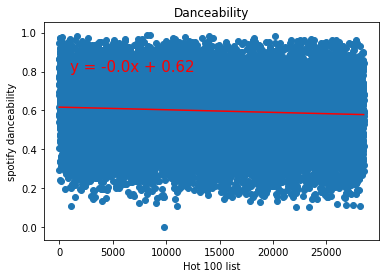

In [46]:
# create a scatter plot based on the track popularity versus the ranking in the top 100.  

plot_func(hot100_clean_df['index'], hot100_clean_df['danceability'],1000,.8,'Hot 100 list',
          'spotify danceability','Danceability')


In [18]:
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json
import time



# example tid to be pulled from excel
tid = '7ytR5pFWmSjzHJIeQkgog4'

client_credentials_manager = SpotifyClientCredentials(client_id='09b1d71bfca845e9b744f70294704da2',
                           client_secret='581c60a4f6c347be9a749bf0a1bb5634')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


if len(sys.argv) > 1:
    features = sp.audio_features(tid)

    print(json.dumps(features, indent=4))
print(f'danceability: {features[0]["danceability"]}')

[
    {
        "danceability": 0.746,
        "energy": 0.69,
        "key": 11,
        "loudness": -7.956,
        "mode": 1,
        "speechiness": 0.164,
        "acousticness": 0.247,
        "instrumentalness": 0,
        "liveness": 0.101,
        "valence": 0.497,
        "tempo": 89.977,
        "type": "audio_features",
        "id": "7ytR5pFWmSjzHJIeQkgog4",
        "uri": "spotify:track:7ytR5pFWmSjzHJIeQkgog4",
        "track_href": "https://api.spotify.com/v1/tracks/7ytR5pFWmSjzHJIeQkgog4",
        "analysis_url": "https://api.spotify.com/v1/audio-analysis/7ytR5pFWmSjzHJIeQkgog4",
        "duration_ms": 181733,
        "time_signature": 4
    }
]
danceability: 0.746


In [12]:
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

#SPOTIPY_CLIENT_ID='09b1d71bfca845e9b744f70294704da2'
#SPOTIPY_CLIENT_SECRET='581c60a4f6c347be9a749bf0a1bb5634'
#SPOTIPY_REDIRECT_URI='https://localhost:8080/'

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

token = util.prompt_for_user_token(username,
                           scope,
                           client_id='09b1d71bfca845e9b744f70294704da2',
                           client_secret='581c60a4f6c347be9a749bf0a1bb5634',
                           redirect_uri='http://127.0.0.1:8080')

if token:
    features = sp.audio_features('7ytR5pFWmSjzHJIeQkgog4')
    print(json.dumps(features, indent=4))

else:
    print("Can't get token for", username)

[
    {
        "danceability": 0.746,
        "energy": 0.69,
        "key": 11,
        "loudness": -7.956,
        "mode": 1,
        "speechiness": 0.164,
        "acousticness": 0.247,
        "instrumentalness": 0,
        "liveness": 0.101,
        "valence": 0.497,
        "tempo": 89.977,
        "type": "audio_features",
        "id": "7ytR5pFWmSjzHJIeQkgog4",
        "uri": "spotify:track:7ytR5pFWmSjzHJIeQkgog4",
        "track_href": "https://api.spotify.com/v1/tracks/7ytR5pFWmSjzHJIeQkgog4",
        "analysis_url": "https://api.spotify.com/v1/audio-analysis/7ytR5pFWmSjzHJIeQkgog4",
        "duration_ms": 181733,
        "time_signature": 4
    }
]
